In [45]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [46]:
data_train = load_dataset("wmt16", "de-en", split="train[:50000]")
data_val = load_dataset("wmt16", "de-en", split="validation")

In [47]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item["translation"]["en"]
        target_text = item["translation"]["de"]

        input_ids = self.tokenizer.encode(input_text, padding='max_length', max_length=128, return_tensors='pt', truncation=True)
        target_ids = self.tokenizer.encode(target_text, padding='max_length', max_length=128, return_tensors='pt', truncation=True)

        return {"input_ids": input_ids, "labels": target_ids}
    
    def evaluate(self, model, dataloader):
        model.eval()
        references = []
        translations = []
        for batch in dataloader:
            input_ids = batch["input_ids"].squeeze(1).to(device)
            labels = batch["labels"].squeeze(1).to(device)
            outputs = model.generate(input_ids=input_ids, max_length=128, num_beams=4, early_stopping=True)
            translated_sentences = [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            references.extend([self.tokenizer.decode(label, skip_special_tokens=True) for label in labels])
            translations.extend(translated_sentences)
        return references, translations

train_dataset = TranslationDataset(data_train)
val_dataset = TranslationDataset(data_val)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [49]:
config = T5Config.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small", config=config)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [51]:
def train(model, optimizer, train_loader, val_loader, num_epochs=2):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].squeeze(1).to(device)
            labels = batch["labels"].squeeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].squeeze(1).to(device)
                labels = batch["labels"].squeeze(1).to(device)

                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    return train_losses, val_losses


In [52]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [53]:
train_losses, val_losses = train(model, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Train Loss: 0.4960833856797218, Val Loss: 0.4189342671238324
Epoch 2/10, Train Loss: 0.4619686749815941, Val Loss: 0.43694400507956743
Epoch 3/10, Train Loss: 0.4352102448308468, Val Loss: 0.448358174687361
Epoch 4/10, Train Loss: 0.4152843062949181, Val Loss: 0.4618224330958636
Epoch 5/10, Train Loss: 0.39780739733338355, Val Loss: 0.46556915704380064
Epoch 6/10, Train Loss: 0.3829976811170578, Val Loss: 0.4798998889129828
Epoch 7/10, Train Loss: 0.36959838216781615, Val Loss: 0.49015881091027574
Epoch 8/10, Train Loss: 0.35707499348044397, Val Loss: 0.5030501488157931
Epoch 9/10, Train Loss: 0.34593883629202843, Val Loss: 0.5082125968902427
Epoch 10/10, Train Loss: 0.3361421949696541, Val Loss: 0.5183319751830662


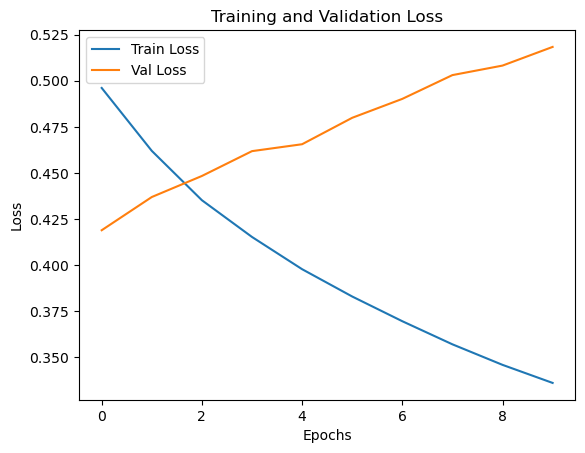

In [54]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [55]:
# Save the trained model
torch.save(model.state_dict(), 'task2C.pt')

In [56]:
# Load the saved model
loaded_model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")
loaded_model.load_state_dict(torch.load('task2C.pt'))
loaded_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [65]:
from datasets import load_metric

# Load evaluation metrics
bleu_metric = load_metric("sacrebleu")
meteor_metric = load_metric("meteor")
bert_metric = load_metric("bertscore")

# Define a function to compute evaluation metrics
def compute_metrics(references, translations):
    #bleu_score = bleu_metric.compute(predictions=translations, references=references)
    meteor_score = meteor_metric.compute(predictions=translations, references=references)
    bert_score = bert_metric.compute(predictions=translations, references=references, lang="de" )
    precision = bert_score["f1"]
    avg = sum(precision) / len(precision)
    
    #bert_score_mean = sum(score['f1'] for score in bert_score) / len(bert_score)
    
    return {"meteor": meteor_score['meteor'], "bert_score": avg}

/home/deb/.local/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/deb/.local/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load thi

In [58]:
val_references, val_translations = val_dataset.evaluate(loaded_model, val_loader)
data_test = load_dataset("wmt16","de-en", split="test")
test_dataset = TranslationDataset(data_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
test_references, test_translations = test_dataset.evaluate(loaded_model, test_loader)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [59]:
print(val_translations[:5])
print(val_references[:5])

['In Tokio treffen die indischen und die japanischen Ministerpräsidenten in Indien und Japan bei den Regierungschefs in Indien und Japan.', 'Der neue indische Ministerpräsident Narendra Modi tagt mit seinem japanischen Kollegen Shinzo Abe in Tokio, um die wirtschaftlichen und Sicherheitsbeziehungen zu diskutieren, während seine erste große Außenreise seit den Wahlen im Mai in Tokio stattfindet.', 'Herr Modi ist auf einer fünftägigen Fünftagereise nach Japan, um die Wirtschaftsbeziehungen mit der drittgrößten Wirtschaft der Welt zu stärken.', 'Hoch auf der Tagesordnung stehen Pläne für eine verstärkte nukleare Zusammenarbeit.', 'Indien hofft ebenfalls auf ein Abkommen über die Verteidigungszusammenarbeit zwischen den beiden Nationen. Indien hofft außerdem auf ein Abkommen über die Verteidigungszusammenarbeit zwischen den beiden Ländern.']
['Die Premierminister Indiens und Japans trafen sich in Tokio.', 'Indiens neuer Premierminister Narendra Modi trifft bei seinem ersten wichtigen Ausla

In [66]:
val_metrics = compute_metrics(val_references, val_translations)
test_metrics = compute_metrics(test_references, test_translations)

In [67]:
#print("Validation BLEU Score:", val_metrics['bleu'])
print("Validation METEOR Score:", val_metrics['meteor'])
print("Validation BERT Score:", val_metrics['bert_score'])

#print("Test BLEU Score:", test_metrics['bleu'])
print("Test METEOR Score:", test_metrics['meteor'])
print("Test BERT Score:", test_metrics['bert_score'])

Validation METEOR Score: 0.4458422493541329
Validation BERT Score: 0.8247643621520767
Test METEOR Score: 0.46949164327482223
Test BERT Score: 0.83179149509629


In [69]:
bleu_val_ref = [[x] for x in val_references]
bleu_test_ref = [[x] for x in test_references]

In [70]:
import evaluate
bleu = evaluate.load('bleu')

2024-03-31 00:49:05.730550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 00:49:05.842994: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [72]:
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=1)
print("Validation BLEU-1 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=2)
print("Validation BLEU-2 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=3)
print("Validation BLEU-3 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=4)
print("Validation BLEU-4 Score:", bleu_score)
print("\n")
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 1)
print("Test BLEU-1 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 2)
print("Test BLEU-2 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 3)
print("Test BLEU-3 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 4)
print("Test BLEU-4 Score:", bleu_score)

Validation BLEU-1 Score: {'bleu': 0.4691296554471221, 'precisions': [0.4691296554471221], 'brevity_penalty': 1.0, 'length_ratio': 1.1352023513452407, 'translation_length': 50210, 'reference_length': 44230}
Validation BLEU-2 Score: {'bleu': 0.3178839743620898, 'precisions': [0.4691296554471221, 0.2153993463916238], 'brevity_penalty': 1.0, 'length_ratio': 1.1352023513452407, 'translation_length': 50210, 'reference_length': 44230}
Validation BLEU-3 Score: {'bleu': 0.2271528290207232, 'precisions': [0.4691296554471221, 0.2153993463916238, 0.1159891008174387], 'brevity_penalty': 1.0, 'length_ratio': 1.1352023513452407, 'translation_length': 50210, 'reference_length': 44230}
Validation BLEU-4 Score: {'bleu': 0.16645287328251132, 'precisions': [0.4691296554471221, 0.2153993463916238, 0.1159891008174387, 0.06549539038729897], 'brevity_penalty': 1.0, 'length_ratio': 1.1352023513452407, 'translation_length': 50210, 'reference_length': 44230}


Test BLEU-1 Score: {'bleu': 0.4914096696465489, 'pre

In [78]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
import pandas as pd
sentences = pd.read_csv("input_2B.csv")
sentences['de'] = ""
for i in range(len(sentences)):
    input_text = "translate English to German: " + sentences['en'][i]
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sentences['de'][i] = translated
sentences.to_csv("task2C.csv", index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
